In [3]:
# input noise --> concatenate one-hot label
# fully connected layer
# reshape to make matrix
# conv 2d to make channels
# convtranspose 2d to upsample to 28x28 dimensions of MNIST


In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 96x96 → 48x48
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),           # 48x48 → 24x24
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),          # 24x24 → 12x12
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 12 * 12, latent_dim)
        self.fc_logvar = nn.Linear(128 * 12 * 12, latent_dim)

    def forward(self, x):
        x = self.encoder(x)                    # shape: (B, 128, 12, 12)
        x = self.flatten(x)                    # shape: (B, 128*12*12)
        mu = self.fc_mu(x)                     # shape: (B, latent_dim)
        logvar = self.fc_logvar(x)             # shape: (B, latent_dim)
        return mu, logvar


In [5]:
class Decoder(nn.Module):
    def __init__(self, out_channels=4, latent_dim=128):
        super().__init__()

        self.fc = nn.Linear(latent_dim, 128 * 12 * 12)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 12, 12)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 12 → 24
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 24 → 48
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1)  # 48 → 96
        )

    def forward(self, x):
        x = self.fc(x)         # (B, latent_dim) → (B, 128*12*12)
        x = self.decoder(x)    # (B, 128*12*12) → (B, out_channels, 96, 96)
        return x


In [11]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * logvar

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar


In [8]:
import matplotlib.pyplot as plt

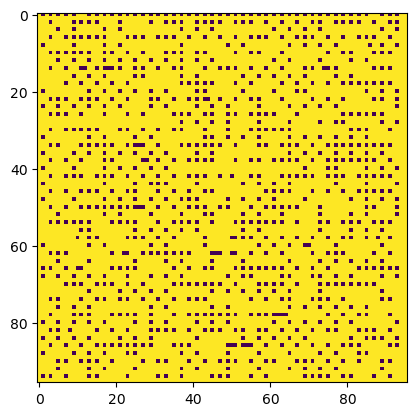

In [18]:
encoder = Encoder()
decoder = Decoder()
vae = VAE(encoder, decoder)

x = torch.randn(1, 1, 96, 96)
image, mu, logvar = vae(x)

plt.imshow(image.squeeze().argmax(dim=0).detach().cpu().numpy(), cmap='viridis')


This is a VAE that will ideally create realistic segmentation masks

In [21]:
print(image.detach())

tensor([[[[-0.0522, -0.0527, -0.0610,  ..., -0.0549, -0.0595, -0.0514],
          [-0.0662, -0.0565, -0.0620,  ..., -0.0528, -0.0638, -0.0619],
          [-0.0554, -0.0648, -0.0681,  ..., -0.0593, -0.0642, -0.0576],
          ...,
          [-0.0660, -0.0502, -0.0656,  ..., -0.0477, -0.0623, -0.0642],
          [-0.0540, -0.0664, -0.0663,  ..., -0.0645, -0.0700, -0.0591],
          [-0.0558, -0.0499, -0.0521,  ..., -0.0513, -0.0533, -0.0612]],

         [[ 0.0139,  0.0316,  0.0146,  ...,  0.0308,  0.0154,  0.0208],
          [ 0.0056, -0.0075,  0.0182,  ..., -0.0058,  0.0225, -0.0021],
          [ 0.0134,  0.0192,  0.0157,  ...,  0.0233,  0.0105,  0.0207],
          ...,
          [ 0.0066, -0.0049,  0.0186,  ..., -0.0072,  0.0188, -0.0063],
          [ 0.0133,  0.0234,  0.0143,  ...,  0.0187,  0.0109,  0.0188],
          [ 0.0145,  0.0018,  0.0150,  ...,  0.0020,  0.0139,  0.0036]],

         [[-0.0679, -0.0548, -0.0735,  ..., -0.0553, -0.0738, -0.0550],
          [-0.0544, -0.0560, -